# RNN Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [1]:
!pip install torchtext==0.4

     |████████████████████████████████| 61kB 8.3MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Mounted at /content/drive
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Load and preprocces the dataframe

In [3]:
path = '/content/drive/MyDrive/Language, speech and dialogue processing/blogtext_full.xlsx'

In [4]:
dataset = pd.read_excel(path)
df = pd.DataFrame(dataset)
df = df.drop(['id', 'topic', 'sign', 'date', 'gender'], axis=1)

df = df.sample(300000)
ages = df["age"].unique().tolist()
print(ages)


[26, 16, 25, 37, 33, 23, 24, 15, 17, 36, 45, 27, 40, 35, 48, 34, 14, 13, 38, 44, 43, 46, 39, 42, 41, 47]


In [5]:
ages.sort()
age_dict = {}
for age in ages:
  age_dict[age] = df.loc[df['age'] == age]

for key, value in age_dict.items():
  age_dict[key] = value
  
print(age_dict)


{13:         age                                               text
233925   13             Hmm, I just saw Franz Ferdinand (th...
496213   13  Another March thing: new glasses   I NEED to b...
169889   13  Hello.  Hi baby, I miss you so much you know? ...
147261   13               Griffin: Griffins are gorgeous cr...
169897   13                   Sigh. Just watched The Day Af...
...     ...                                                ...
52404    13  If you didnt know, i have another life outside...
520980   13         Hello there! There's this kid at school...
4168     13          Ok, now Im getting pissed off >>;;;;  ...
260656   13             I have always like Calvin. If he co...
310235   13  Do we have sci on wedneasday?  We do have F-CA...

[5832 rows x 2 columns], 14:         age                                               text
207290   14  HELLO PEOPLE WHATS UP...NOT MUCH HERE JUST HAT...
87560    14                        I am the one and only gu...
103821   14  tbs is 

In [6]:
# Same range as in pan13 dataset

dataframes_10s = []
dataframes_20s = []
dataframes_30s = []
dataframes_40s = []

for key, value in age_dict.items():
  if 13 <= int(key) <= 17:
    dataframes_10s.append(value)
  elif 23 <= int(key) <= 27:
    dataframes_20s.append(value)
  elif 33 <= int(key) <= 37:
    dataframes_30s.append(value)
  elif 43 <= int(key) <= 47:
    dataframes_40s.append(value)

df_10s = pd.concat(dataframes_10s)
df_20s = pd.concat(dataframes_20s)
df_30s = pd.concat(dataframes_30s)
df_40s = pd.concat(dataframes_40s)

all_dataframes = [df_10s, df_20s, df_30s, df_40s]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

df_10s["age"] = 0
df_20s["age"] = 1
df_30s["age"] = 2
df_40s['age'] = 3

all_dataframes = [df_10s.sample(min_len), df_20s.sample(min_len), df_30s.sample(min_len), df_40s.sample(min_len)]


df = pd.concat(all_dataframes)



In [7]:
df

,age,text
179255,0,"I'm tired, as the title suggests, but I..."
504909,0,Chess and Go Ahhh... it's been awhile sinc...
515394,0,I just took the collegeboard test and I have t...
144559,0,Great Song: We Bow Down: We bow bown and ...
306340,0,'A moon full of stars and astral ...
...,...,...
496746,3,BLOGGER MESSED WITH MY BEANO
2282,3,"Still it has little, I had t..."
267434,3,"Which Way, Bill Magavern? Listen to m..."
255927,3,Oswald Sobrino at Catholic Analysis looks at t...


## 3. Create n_grams from the text (Optional)

In [8]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    wrong_words = ["urllink", "nbsp"]
    tokens = [token for token in text.split(" ") if token != "" and token not in wrong_words]
    return tokens

def lowered(s):
    return s.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [9]:
df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)
print(df['text'].iloc[0])
print(df['text'])

['i', 'm', 'tired', 'as', 'the', 'title', 'suggests', 'but', 'i', 'm', 'a', 'bit', 'happier', 'i', 'spent', 'my', 'day', 'mainly', 'in', 'two', 'places', 'school', 'and', 'anthony', 's', 'house', 'school', 'for', 'once', 'rocked', 'jay', 's', 'band', 'played', 'and', 'i', 'was', 'like', 'woohoo', 'heh', 'they', 'really', 'were', 'good', 'even', 'if', 'i', 'didn', 't', 'like', 'jay', 'i', 'd', 'still', 'hafta', 'admit', 'that', 'they', 'rocked', 'mrs', 'marak', 'wasn', 't', 'as', 'bitchy', 'as', 'she', 'normally', 'is', 'and', 'after', 'not', 'talking', 'to', 'jay', 'random', 'not', 'like', 'mad', 'at', 'him', 'just', 'kinda', 'not', 'been', 'able', 'to', 'since', 'last', 'saturday', 'i', 'saw', 'him', 'a', 'lot', 'today', 'and', 'he', 'imed', 'me', 'so', 'i', 'guess', 'you', 'could', 'say', 'i', 'm', 'in', 'a', 'good', 'mood', 'i', 'm', 'not', 'happy', 'not', 'by', 'a', 'long', 'shot', 'but', 'i', 'm', 'uh', 'not', 'even', 'content', 'um', 'i', 'don', 't', 'know', 'i', 'don', 't', 'kno

In [10]:
df.index = range(len(df))


Pre processing data loader

In [11]:
class_choice = 'age'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

[0, 1, 2, 3]
classdict:
{0: 6891, 1: 6891, 2: 6891, 3: 6891}


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [12]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

{'the': 260249, 'i': 219413, 'to': 178587, 'and': 163536, 'a': 134176, 'of': 119196, 'it': 86409, 'in': 85081, 'that': 84896, 'is': 65159, 'my': 58649, 'you': 57101, 'for': 55972, 's': 55755, 'was': 51302, 'on': 45964, 't': 41244, 'with': 39952, 'this': 39015, 'have': 38871, 'but': 38335, 'me': 37762, 'we': 35444, 'so': 35443, 'be': 35165, 'he': 33180, 'not': 31519, 'at': 31223, 'as': 29676, 'all': 27105, 'are': 26566, 'they': 25577, 'just': 22671, 'like': 22123, 'out': 21957, 'what': 21874, 'up': 21668, 'about': 21501, 'or': 21428, 'one': 21127, 'can': 21040, 'from': 20839, 'm': 20762, 'she': 20169, 'if': 19637, 'there': 19485, 'her': 19260, 'had': 18954, 'do': 18487, 'will': 17804, 'when': 17793, 'his': 17732, 'by': 17185, 'get': 16704, 'time': 15846, 'some': 15082, 'an': 15080, 'who': 14728, 'know': 14501, 'now': 14461, 'no': 14374, 'more': 14305, 'would': 14043, 'your': 13938, 'then': 13412, 'don': 13365, 'has': 13246, 'people': 12814, 'am': 12759, 'were': 12698, 'been': 12536, 'go

In [13]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

{'the': 0, 'i': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'it': 6, 'in': 7, 'that': 8, 'is': 9, 'my': 10, 'you': 11, 'for': 12, 's': 13, 'was': 14, 'on': 15, 't': 16, 'with': 17, 'this': 18, 'have': 19, 'but': 20, 'me': 21, 'we': 22, 'so': 23, 'be': 24, 'he': 25, 'not': 26, 'at': 27, 'as': 28, 'all': 29, 'are': 30, 'they': 31, 'just': 32, 'like': 33, 'out': 34, 'what': 35, 'up': 36, 'about': 37, 'or': 38, 'one': 39, 'can': 40, 'from': 41, 'm': 42, 'she': 43, 'if': 44, 'there': 45, 'her': 46, 'had': 47, 'do': 48, 'will': 49, 'when': 50, 'his': 51, 'by': 52, 'get': 53, 'time': 54, 'some': 55, 'an': 56, 'who': 57, 'know': 58, 'now': 59, 'no': 60, 'more': 61, 'would': 62, 'your': 63, 'then': 64, 'don': 65, 'has': 66, 'people': 67, 'am': 68, 'were': 69, 'been': 70, 'go': 71, 'them': 72, 'really': 73, 'think': 74, 'him': 75, 'well': 76, 'how': 77, 'good': 78, 'their': 79, 'back': 80, 'day': 81, 'our': 82, 'got': 83, 'going': 84, 'because': 85, 'see': 86, 'much': 87, 'which': 88, 'only': 89, 'in

## 8. Mapping text column to numbers (tensor)

In [14]:
import numpy as np
text_int_list = []
text_lengths = []
for i, text in enumerate(df['text']):
  newtext = []
  lens = []
  for word in text:
    newtext.append(int(wordmap[word]))
  text_lengths.append(len(newtext))
  text_int_list.append(newtext)
average_len = int(sum(text_lengths) / len(text_lengths))
df["lengths"] = text_lengths

encoding_padded = []
for ints in text_int_list:
  N = average_len
  zeros = np.zeros(N, dtype=int)
  encoded = zeros
  length = min(N, len(ints))
  encoded[:length] = ints[:length]
  encoding_padded.append(np.array((encoded, len(ints))))

df["encoded"] = encoding_padded
df



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,age,text,lengths,encoded
0,0,"[i, m, tired, as, the, title, suggests, but, i...",184,"[[1, 42, 487, 28, 0, 1099, 4398, 20, 1, 42, 4,..."
1,0,"[chess, and, go, ahhh, it, s, been, awhile, si...",243,"[[8172, 3, 71, 4326, 6, 13, 70, 1490, 168, 1, ..."
2,0,"[i, just, took, the, collegeboard, test, and, ...",141,"[[1, 32, 244, 0, 45702, 660, 3, 1, 19, 2, 1127..."
3,0,"[great, song, we, bow, down, we, bow, bown, an...",49,"[[154, 433, 22, 5635, 124, 22, 5635, 45704, 3,..."
4,0,"[a, moon, full, of, stars, and, astral, cars, ...",123,"[[4, 1750, 373, 5, 1772, 3, 60927, 1494, 9, 41..."
...,...,...,...,...
27559,3,"[blogger, messed, with, my, beano]",5,"[[1178, 2834, 17, 10, 55404, 0, 0, 0, 0, 0, 0,..."
27560,3,"[still, it, has, little, i, had, the, necessit...",308,"[[114, 6, 66, 122, 1, 47, 0, 7225, 2, 24, 2, 1..."
27561,3,"[which, way, bill, magavern, listen, to, my, o...",42,"[[88, 101, 792, 16505, 734, 2, 10, 449, 0, 896..."
27562,3,"[oswald, sobrino, at, catholic, analysis, look...",240,"[[19598, 33015, 27, 1597, 3306, 486, 27, 0, 33..."


In [15]:
X = list(df['encoded'])
y = list(df['age'])
print(X[0])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

[array([    1,    42,   487,    28,     0,  1099,  4398,    20,     1,
          42,     4,   256,  3737,     1,   505,    10,    81,  2543,
           7,   131,   954,   183,     3,  4879,    13,   182,   183,
          12,   245,  5593,  2678,    13,   597,   602,     3,     1,
          14,    33,  4644,  1794,    31,    73,    69,    78,    96,
          44,     1,   148,    16,    33,  2678,     1,   138,   114,
        8320,  1157,     8,    31,  5593,  1745, 60922,   314,    16,
          28,  8033,    28,    43,  1950,     9,     3,    97,    26,
         344,     2,  2678,  1125,    26,    33,   961,    27,    75,
          32,   635,    26,    70,   320,     2,   168,   109,   524,
           1,   294,    75,     4,   189,   102,     3,    25, 22853,
          21,    23,     1,   237,    11,    98,   115,     1,    42,
           7,     4,    78,   879,     1,    42,    26,   263,    26,
          52,     4,   151,   995,    20,     1,    42,  1758,    26,
          96,  1700

In [16]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class BlogDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [18]:
train_ds = BlogDataset(X_train, y_train)
valid_ds = BlogDataset(X_valid, y_valid)

**TO-DO:**

*   Confusion matrix
*   Activation words





In [19]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/Blog_rnn_confusion_matrix.png')
    

In [20]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            l = l.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            x, y, l = x.to(device), y.to(device), l.to(device)
            loss = F.cross_entropy(y_pred, y).to(device)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        train_loss = sum_loss/total
        print('Epoch: %d' %(i + 1))
        print(f'\tLoss: {train_loss:.4f}(train)\t')
        print(f'\tLoss: {val_loss:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid) | \tRMSE: {val_rmse * 100:.1f}(valid)')
        if i == (epochs-1):
          predictions, labels = validation_metrics(model, val_dl, True)
          conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1, 2, 3])
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          #plt.figure()
          plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s', '40s'], normalize=True, title='Blog RNN Confusion matrix, with normalization')



def validation_metrics (model, valid_dl, last_epoch=False):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    predictions = []
    labels = []
    for x, y, l in valid_dl:
        x,y,l = x.to(device), y.to(device), l.to(device)
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(1)
        predict = pred.to('cpu')
        label = y.to('cpu')
        predictions.extend(predict)
        labels.extend(label)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.unsqueeze(-1).cpu()))*y.shape[0]
    if last_epoch == False:
      return sum_loss/total, correct/total, sum_rmse/total
    else:
      return predictions, labels



In [21]:
batch_size = 256
vocab_size = len(vocabdict)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [22]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [23]:
print(f"Vocab size: {vocab_size}")

# Rule of thumb voor embed dim volgens: 
# (https://datascience.stackexchange.com/questions/31109/ratio-between-embedded-vector-dimensions-and-vocabulary-size)

embedding_dimensions =  int(vocab_size**0.25)

model_fixed =  LSTM_fixed_len(vocab_size, embedding_dimensions, 50).to(device)

Vocab size: 117323


Epoch: 1
	Loss: 1.4055(train)	
	Loss: 1.3873(valid)	|	Acc: 25.3%(valid) | 	RMSE: 184.6(valid)
Epoch: 2
	Loss: 1.3867(train)	
	Loss: 1.3961(valid)	|	Acc: 27.0%(valid) | 	RMSE: 178.9(valid)
Epoch: 3
	Loss: 1.3638(train)	
	Loss: 1.3517(valid)	|	Acc: 32.8%(valid) | 	RMSE: 158.2(valid)
Epoch: 4
	Loss: 1.3596(train)	
	Loss: 1.3978(valid)	|	Acc: 27.3%(valid) | 	RMSE: 177.3(valid)
Epoch: 5
	Loss: 1.2890(train)	
	Loss: 1.3146(valid)	|	Acc: 34.1%(valid) | 	RMSE: 133.1(valid)
Epoch: 6
	Loss: 1.1591(train)	
	Loss: 1.2618(valid)	|	Acc: 40.4%(valid) | 	RMSE: 123.9(valid)
Epoch: 7
	Loss: 1.0584(train)	
	Loss: 1.2863(valid)	|	Acc: 41.0%(valid) | 	RMSE: 112.4(valid)
Epoch: 8
	Loss: 0.9233(train)	
	Loss: 1.3623(valid)	|	Acc: 41.0%(valid) | 	RMSE: 112.1(valid)
Epoch: 9
	Loss: 0.8232(train)	
	Loss: 1.4302(valid)	|	Acc: 43.0%(valid) | 	RMSE: 109.7(valid)
Epoch: 10
	Loss: 0.7316(train)	
	Loss: 1.4417(valid)	|	Acc: 43.7%(valid) | 	RMSE: 109.3(valid)
Epoch: 11
	Loss: 0.6610(train)	
	Loss: 1.4829(valid)	|	Acc:

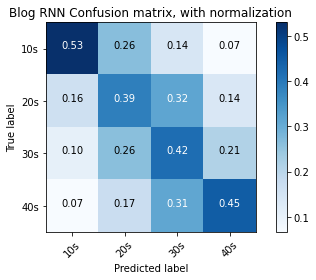

In [24]:

train_model(model_fixed, epochs=100, lr=0.01)

In [25]:
pred = [0,2,1,0,2,1]
labels = [0,1,1,2,1,1]

conf_matrix = confusion_matrix(np.array(labels), np.array(pred), labels=[0, 1, 2])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s'], title='Confusion matrix')

